In [1]:
# Imports para manipulação de dados
import pandas as pd
import numpy as np
import os

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Import dos dados
import yfinance as yf

#Import para tratamento de datas
from datetime import datetime, timedelta

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Import para salvar o modelo
import joblib

# Filtra os warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
Dando os devidos créditos:
Esta função foi recebida no curso de Modelagem de Séries Temporais e Real-Time Analytics 
com Apache Spark e Databricks oferecido pela DSA - Data Science Academy
'''

# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

In [3]:
# Formatação para os gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Formatando os labels dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [5]:
# Carregando os dados
goog = yf.download('GOOG',start='2015-09-21',end='2025-09-21',auto_adjust=False)
goog.columns = ['Adj Close','close','High','Low','Open','Volume']
goog = goog[['close']]
datas = pd.date_range(start='2015-09-21', end='2025-09-21', freq='D')
dados = goog.copy()
dados= dados.reindex(datas)
dados.ffill(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2015-09-21 to 2025-09-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3654 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


In [7]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
close,3654.0,94.054147,49.234043,29.744499,52.616875,77.82225,135.235252,255.240005


In [8]:
dados

,close
2015-09-21,31.771999
2015-09-22,31.134501
2015-09-23,31.118000
2015-09-24,31.290001
2015-09-25,30.598499
...,...
2025-09-17,249.850006
2025-09-18,252.330002
2025-09-19,255.240005
2025-09-20,255.240005


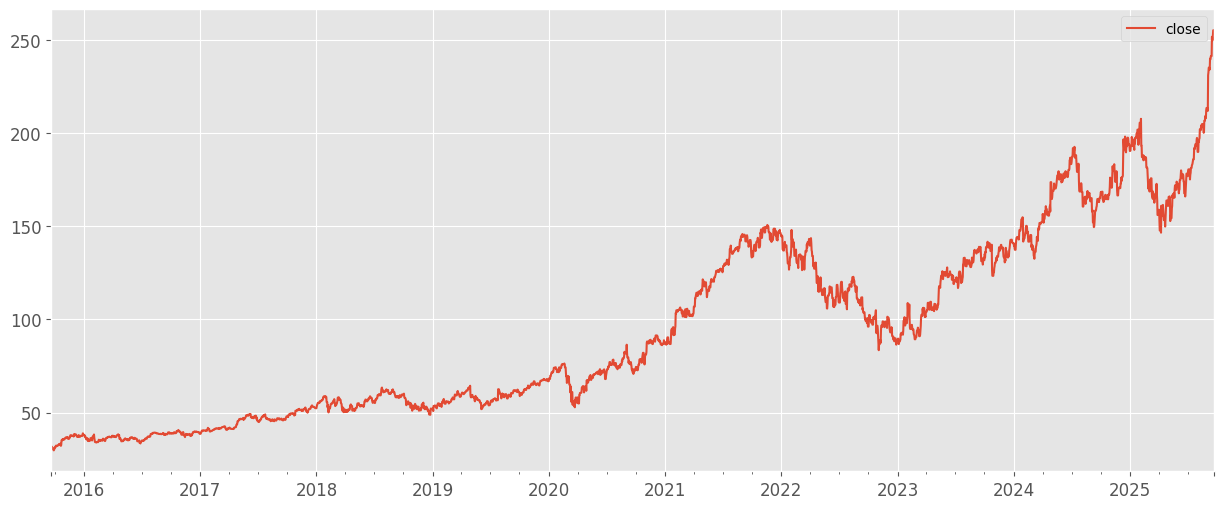

In [9]:
# Plot da Série Temporal 
dados.plot(figsize = (15, 6))
plt.show()

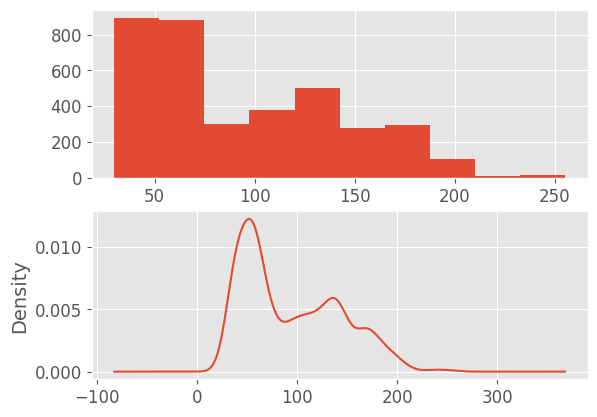

In [10]:
# Gráfico de Densidade

# Plot
plt.figure(1)

# Subplot 1
plt.subplot(211)
dados.close.hist()

# Subplot 2
plt.subplot(212)
dados.close.plot(kind = 'kde')
plt.show()

In [11]:
# Decomposição Multiplicativa
decomposicao_multiplicativa = sm.tsa.seasonal_decompose(dados, 
                                                        model = 'multiplicative', 
                                                        extrapolate_trend = 'freq')

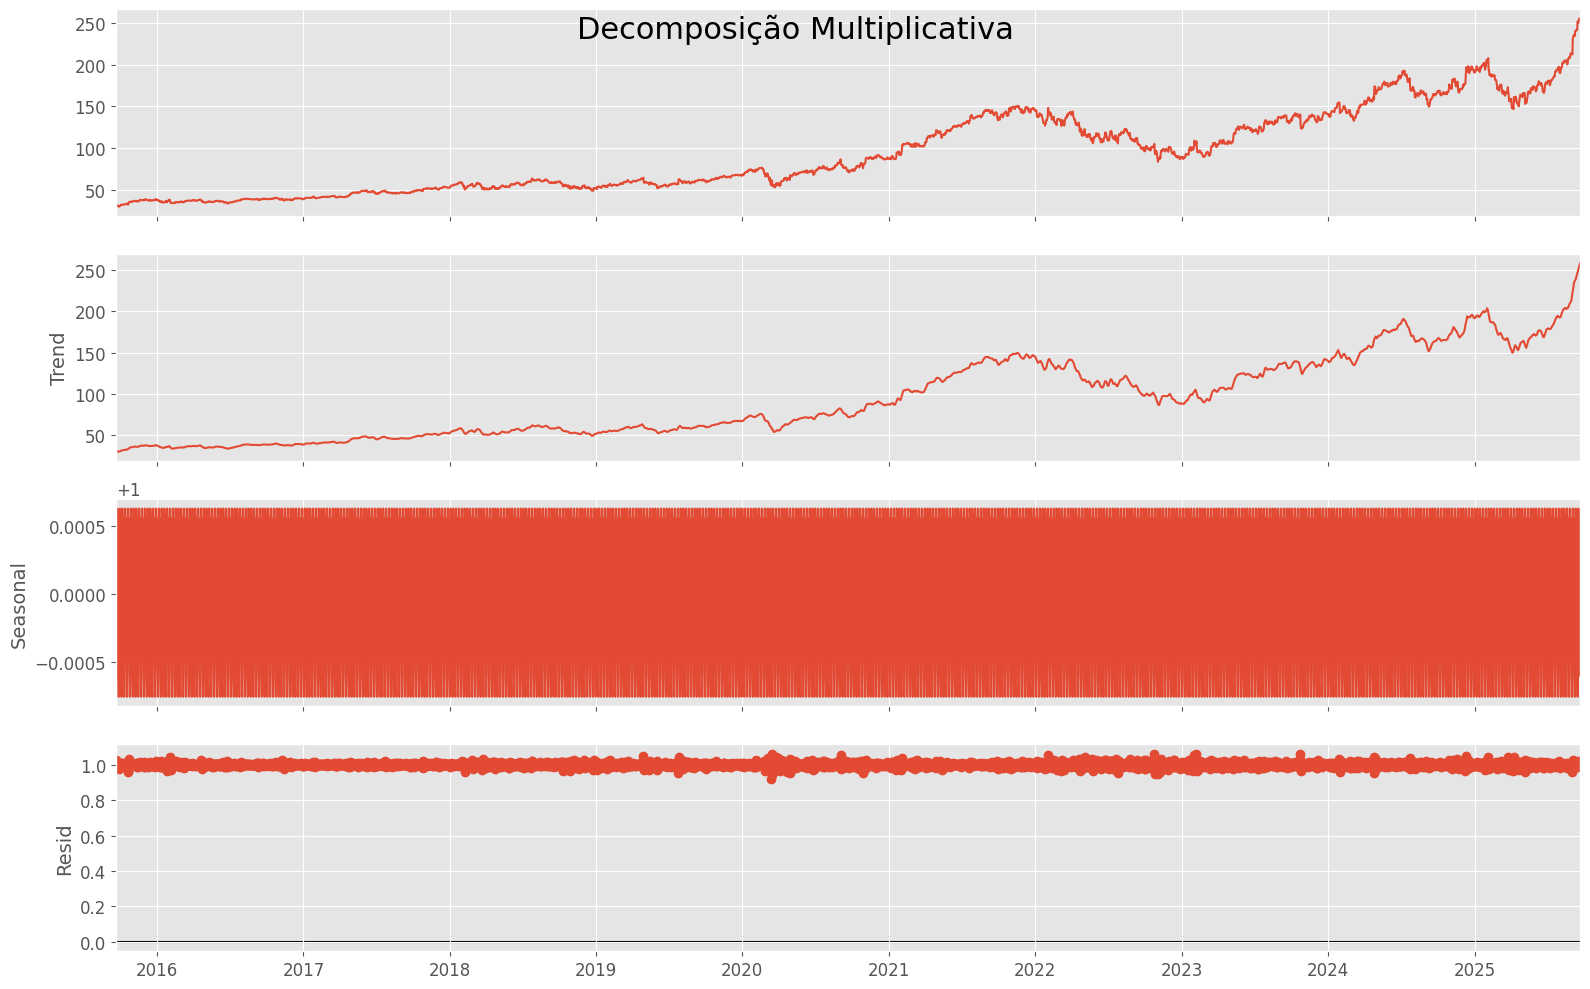

In [12]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_multiplicativa.plot().suptitle('Decomposição Multiplicativa', fontsize = 22)
plt.show()

In [13]:
# Concatena o resultado da decomposição da série
dados_reconstruido = pd.concat([decomposicao_multiplicativa.seasonal, 
                                      decomposicao_multiplicativa.trend, 
                                      decomposicao_multiplicativa.resid, 
                                      decomposicao_multiplicativa.observed], axis = 1)
dados_reconstruido.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']
dados_reconstruido

,Sazonalidade,Tendência,Resíduos,Valores_Observados
2015-09-21,0.999240,31.047117,1.024126,31.771999
2015-09-22,0.999712,30.967671,1.005677,31.134501
2015-09-23,1.000631,30.888224,1.006803,31.118000
2015-09-24,1.000488,31.015714,1.008351,31.290001
2015-09-25,1.000558,30.726071,0.995293,30.598499
...,...,...,...,...
2025-09-17,1.000631,251.031431,0.994666,249.850006
2025-09-18,1.000488,253.011431,0.996820,252.330002
2025-09-19,1.000558,254.502043,1.002341,255.240005
2025-09-20,0.999975,256.298574,0.995894,255.240005


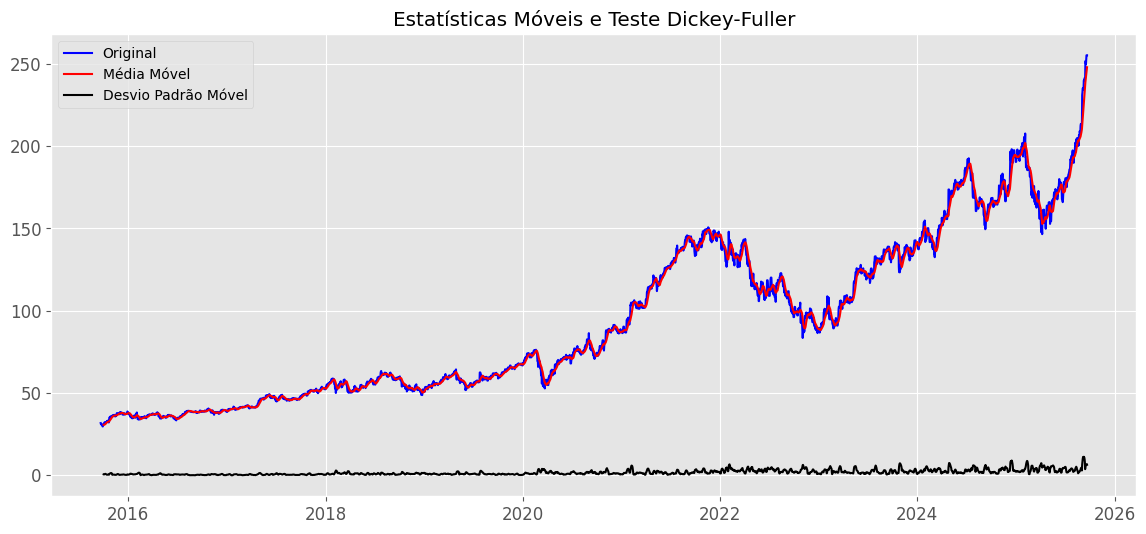


Resultado do Teste Dickey-Fuller:
Estatística do Teste               1.449506
Valor-p                            0.997328
Número de Lags Consideradas       30.000000
Número de Observações Usadas    3623.000000
Valor Crítico (1%)                -3.432156
Valor Crítico (5%)                -2.862338
Valor Crítico (10%)               -2.567195
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [14]:
# Executando a função
dsa_testa_estacionaridade(dados)

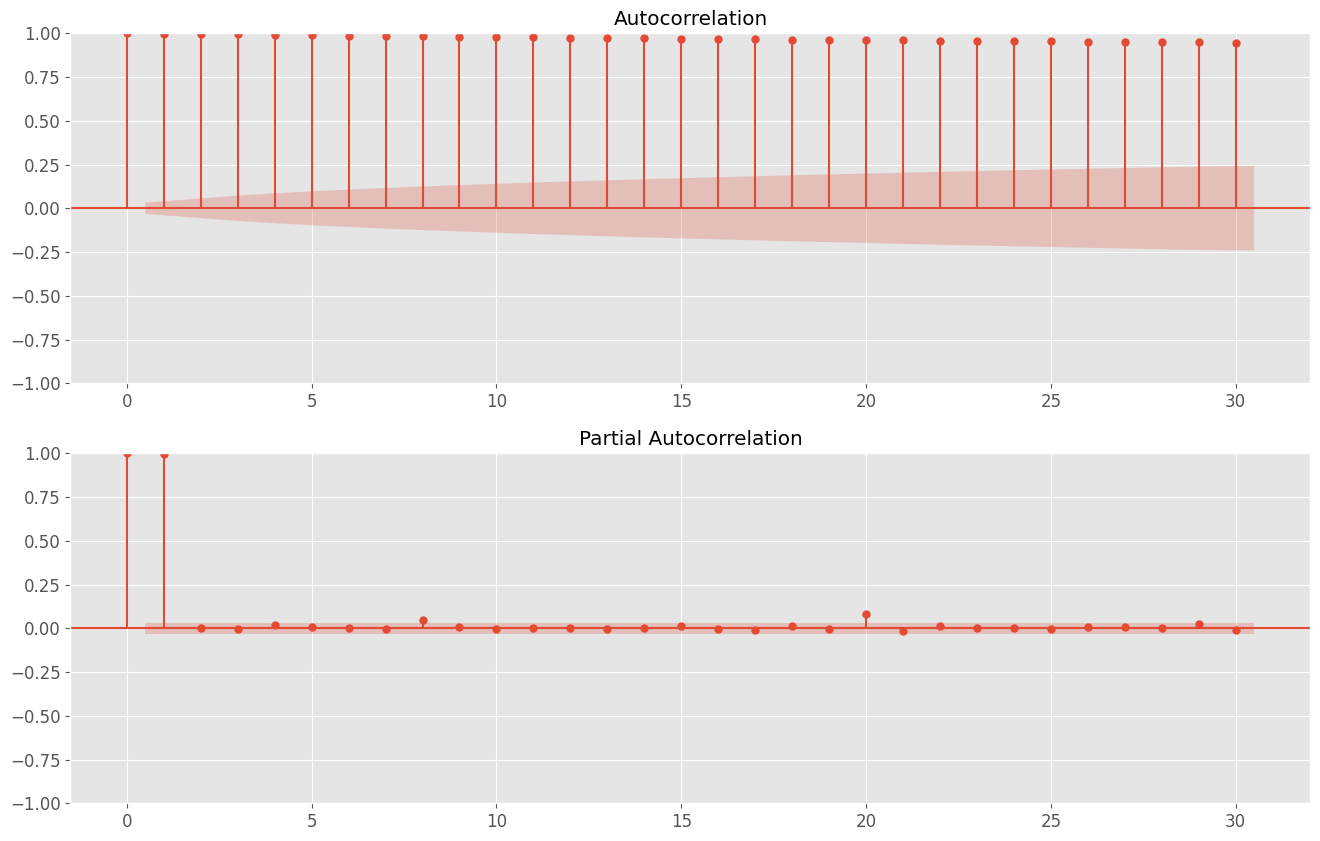

In [15]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(dados.close, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(dados.close, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()

In [12]:
# Transformação de log
dados_log = np.log(dados)

In [13]:
dados_log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2015-09-21 to 2025-09-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3654 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


In [14]:
dados_log

,close
2015-09-21,3.458585
2015-09-22,3.438317
2015-09-23,3.437786
2015-09-24,3.443299
2015-09-25,3.420951
...,...
2025-09-17,5.520861
2025-09-18,5.530738
2025-09-19,5.542204
2025-09-20,5.542204


In [15]:
dados_log['diff'] = dados_log['close'].diff(periods=1)
dados_log.drop('close',axis=1,inplace=True)
dados_log.columns = ['close']

In [16]:
dados_log.dropna(inplace=True)

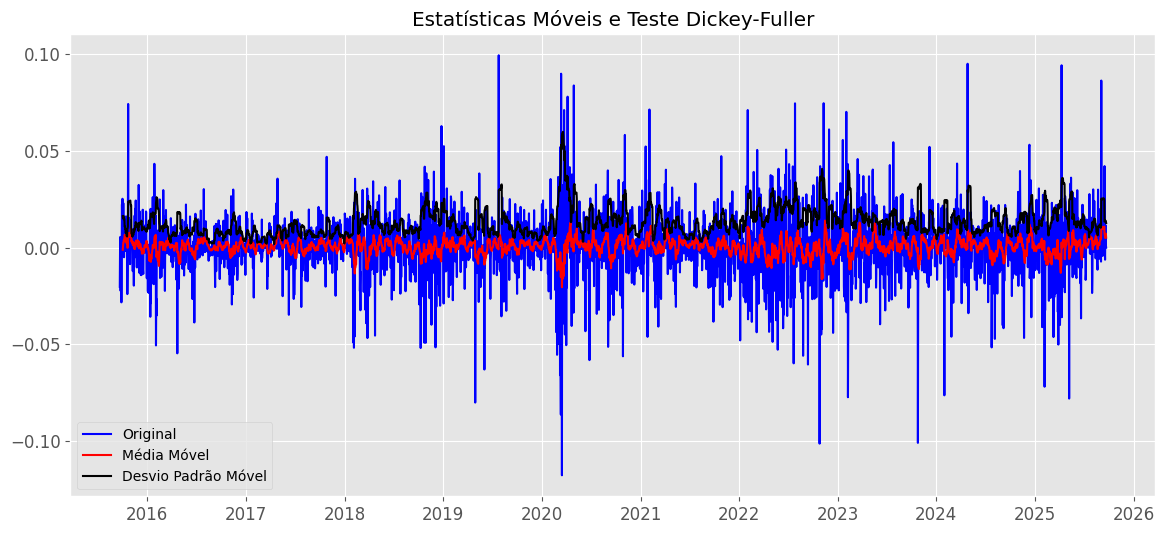


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.176458e+01
Valor-p                         1.126955e-21
Número de Lags Consideradas     2.700000e+01
Número de Observações Usadas    3.625000e+03
Valor Crítico (1%)             -3.432155e+00
Valor Crítico (5%)             -2.862338e+00
Valor Crítico (10%)            -2.567195e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [17]:
dsa_testa_estacionaridade(dados_log)

In [22]:
dados_log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2015-09-22 to 2025-09-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   3653 non-null   float64
dtypes: float64(1)
memory usage: 57.1 KB


In [19]:
# Os dados de treino serão divididos em dados de treino e validação
tam = len(dados_log)
tam = int(tam * .8)
df_treino = dados_log.iloc[0:tam]
df_teste = dados_log.iloc[tam:]

In [20]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2015-09-22 to 2023-09-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2922 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


In [21]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-09-22 to 2025-09-21
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [22]:
df_treino

,close
2015-09-22,-0.020269
2015-09-23,-0.000530
2015-09-24,0.005512
2015-09-25,-0.022348
2015-09-26,0.000000
...,...
2023-09-17,0.000000
2023-09-18,0.004761
2023-09-19,-0.000936
2023-09-20,-0.031017


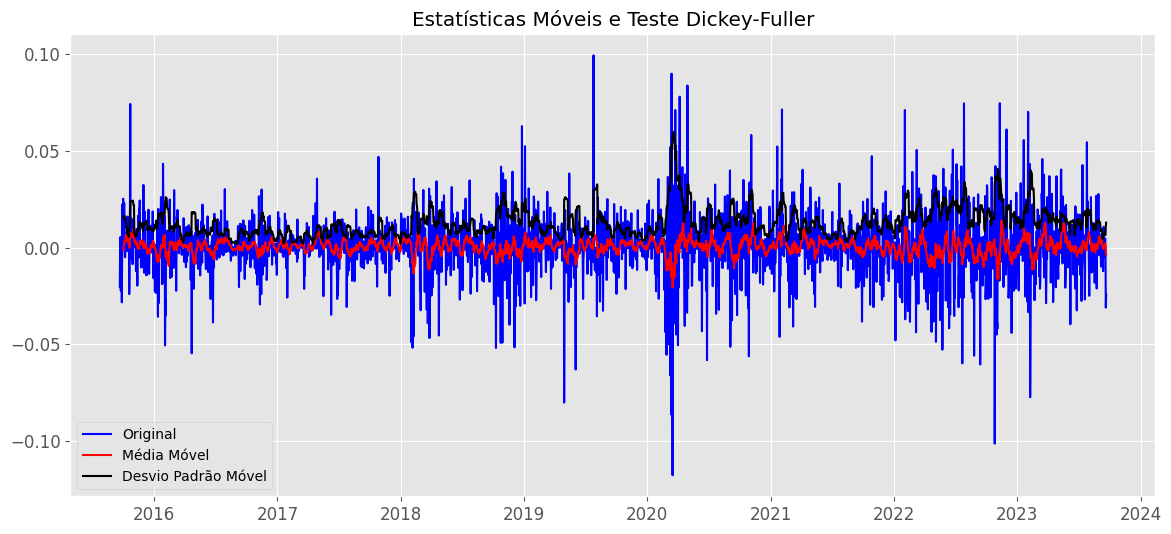


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.497104e+01
Valor-p                         1.200090e-27
Número de Lags Consideradas     1.200000e+01
Número de Observações Usadas    2.909000e+03
Valor Crítico (1%)             -3.432600e+00
Valor Crítico (5%)             -2.862534e+00
Valor Crítico (10%)            -2.567299e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [23]:
dsa_testa_estacionaridade(df_treino)

In [24]:
auto_model = pm.auto_arima(df_treino['close'],
                      start_p=0, start_q=0,
                      max_p=15, 
                      max_q=15, 
                      d=None,
                      seasonal=False, 
                      trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-16311.986, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-16320.306, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-16320.473, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16318.588, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-16318.587, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16317.526, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-16322.054, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-16313.119, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16320.232, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-16320.220, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-16321.852, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-16318.887, Time=0.69 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 3.581 seconds


In [25]:
# Cria o modelo
modelo_ARIMA = ARIMA(df_treino, order = (0, 0, 1), freq = 'D')

In [26]:
# Treinamento do modelo
modelo = modelo_ARIMA.fit()

In [27]:
# Dados Reais e Previsões (em treino)
previsoes = modelo.fittedvalues

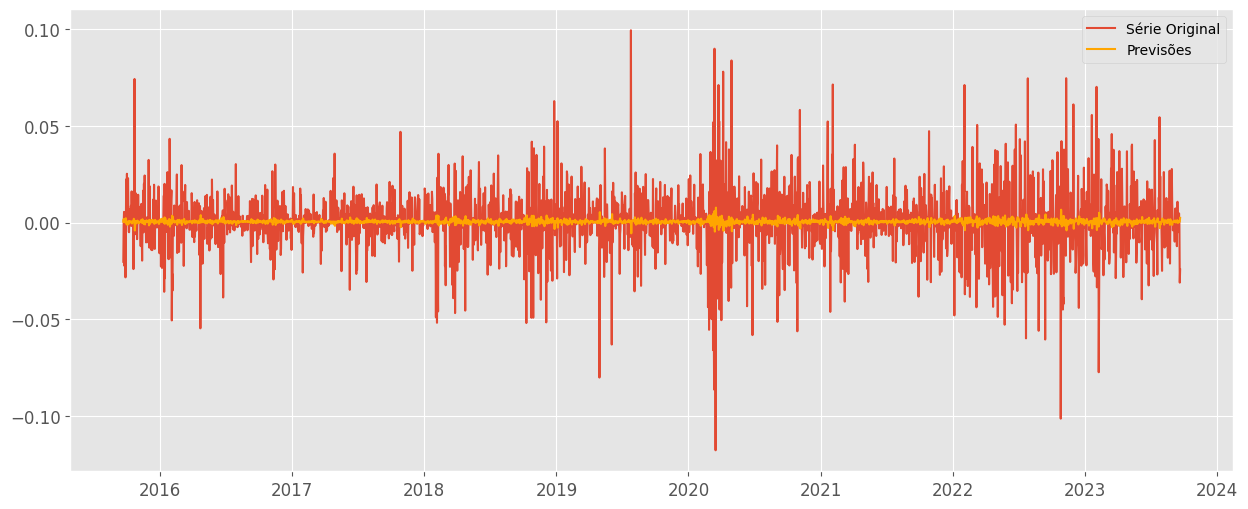

In [30]:
# Plot
plt.figure(figsize = (15, 6))
plt.plot(df_treino, label = 'Série Original') 
plt.plot(previsoes, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Sumário do Modelo 
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2922
Model:                 ARIMA(0, 0, 1)   Log Likelihood                8164.027
Date:                Tue, 23 Sep 2025   AIC                         -16322.054
Time:                        23:37:04   BIC                         -16304.114
Sample:                    09-22-2015   HQIC                        -16315.593
                         - 09-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.881      0.060   -2.03e-05       0.001
ma.L1         -0.0613      0.012     -4.935      0.000      -0.086      -0.037
sigma2         0.0002   2.64e-06     82.872      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7182.63
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes = modelo.forecast(len(df_teste), alpha = 0.05) 

In [32]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes, index = df_teste.index)

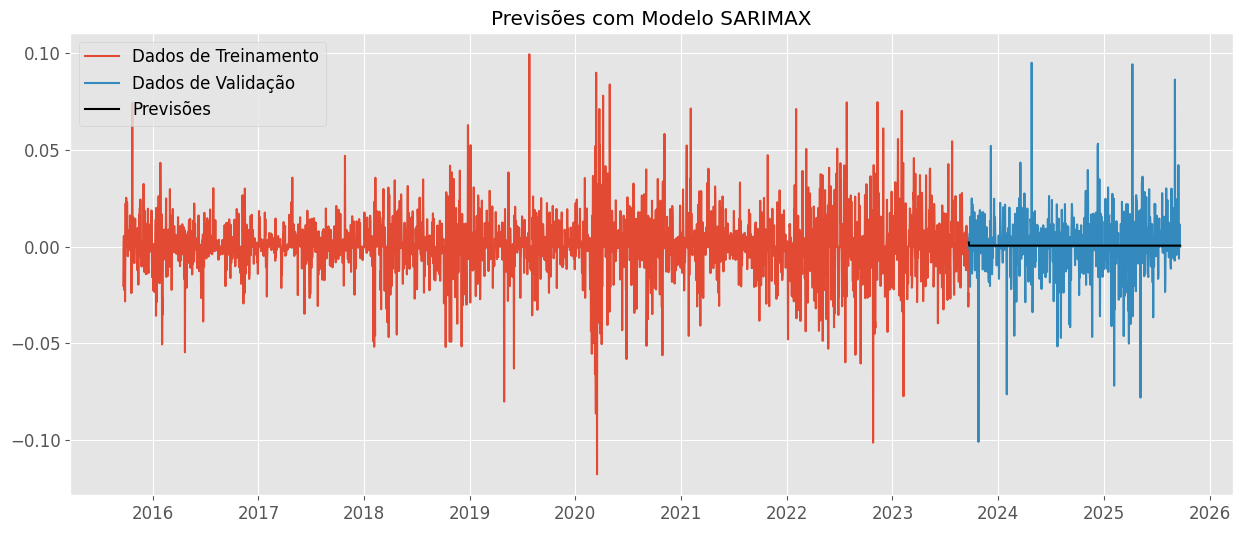

In [33]:
# Plot
plt.figure(figsize = (15, 6))
plt.plot(df_treino, label = 'Dados de Treinamento')
plt.plot(df_teste, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões',color='black')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [34]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [35]:
# Define valor real e valor previsto
y_true = df_teste
y_pred = fc_series

In [36]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.015598281122299168


In [40]:
# Salvando o modelo
model_dir = os.path.join('..', 'Modelos')
os.makedirs(model_dir, exist_ok=True)
filename = 'modelo_google.joblib'
full_path = os.path.join(model_dir, filename)
joblib.dump(modelo, full_path)

['../Modelos/modelo_google.joblib']

In [41]:
joblib.dump(modelo, full_path)

['../Modelos/modelo_google.joblib']